Download the necessary libraries.

Link to data - https://raw.githubusercontent.com/DataSlingers/clustRviz/master/data/authors.rda

Install these if necessary.

In [48]:
# %pip install scikit-learn --quiet
# %pip install adjustText --quiet
# %pip install umap-learn --quiet
# %pip install wordcloud

In [49]:
## Basics
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

## ML Packages
import umap
from sklearn.decomposition import FastICA, NMF, KernelPCA, PCA, TruncatedSVD
from sklearn.preprocessing import StandardScaler, LabelEncoder
from scipy.spatial.distance import pdist, squareform
from sklearn.manifold import SpectralEmbedding, TSNE
from sklearn.model_selection import train_test_split
from sklearn.manifold import MDS

## Msc
from adjustText import adjust_text
from itertools import combinations
from wordcloud import WordCloud

Load dataset.

In [50]:
df = pd.read_csv('00_authors.csv').rename(columns = {'Unnamed: 0': 'Author'}).drop(columns = 'BookID')
X = df.copy().drop(['Author'], axis=1)
authors = df['Author'].values
df

,Author,a,all,also,an,and,any,are,as,at,...,was,were,what,when,which,who,will,with,would,your
0,Austen,46,12,0,3,66,9,4,16,13,...,40,11,7,5,6,8,4,9,1,0
1,Austen,35,10,0,7,44,4,3,18,16,...,27,13,5,7,7,3,5,14,8,0
2,Austen,46,2,0,3,40,1,13,11,9,...,24,6,10,4,6,4,5,15,3,9
3,Austen,40,7,0,4,64,3,3,20,13,...,26,10,3,6,10,5,3,22,4,3
4,Austen,29,5,0,6,52,5,14,17,6,...,23,5,8,4,13,2,4,21,10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
836,Shakespeare,32,4,0,6,33,0,7,8,4,...,0,1,13,2,3,3,11,17,5,10
837,Shakespeare,16,5,0,5,49,1,6,10,3,...,1,1,6,5,6,0,11,20,2,7
838,Shakespeare,22,15,0,3,48,0,9,10,2,...,4,0,16,2,2,0,12,15,1,10
839,Shakespeare,25,4,0,8,59,3,6,7,3,...,3,4,11,2,2,2,22,23,4,5


In [51]:
book_id = df['Author']
book_id.value_counts() # 4 different books ; w/ 317 - Austen, ..., 55 - Milton.

Author
Austen         317
London         296
Shakespeare    173
Milton          55
Name: count, dtype: int64

- Unsupervised learning: drop columns ['Authors'] and determine patterns with words across chapters using unsupervised learning methods.

- We will later come back to these labels we dropped to validate our results.

- Note, a row represents a book chapter with each column representing the word counts of key words in that chapter.

# Linear Methods

## PCA

**PCA Theory**

Given a centered data matrix $X \in \mathbb{R}^{n \times p}$ with:
- $n$: observations (chapters),
- $p$: features (words),

PCA uses the SVD:
$X = U \Sigma V^\top$

- $U \Sigma$ → principal component scores (embedding of chapters),
- $V$ (or `pca.components_`) → principal axes (directions for words).

**No need to transpose** the data to get word embeddings.  
Using `fit_transform(X)` for chapters, and `components_.T` for words — where both come from the same PCA fit.


Also note that when fitting a PCA in this dataset: **WE SHOULD NOT SCALE DATA SINCE IT IS WORD COUNT!!!**

### Observations

In [52]:
pca = PCA()
X_pca = pca.fit_transform(X)
word_loadings = pca.components_.T 

pca_df = pd.DataFrame(X_pca)
cols = [f'PC{j+1}' for j in range(pca_df.shape[1])]
pca_df = pca_df.rename(columns = {i:cols[i] for i in range(pca_df.shape[1])})
pca_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC60,PC61,PC62,PC63,PC64,PC65,PC66,PC67,PC68,PC69
0,-2.265044,43.499301,5.196950,-2.333575,23.359407,22.309224,13.585777,-0.891477,-2.178907,0.062718,...,-2.043904,-3.175850,1.578725,-2.575981,1.463553,-1.107755,-0.341962,2.639943,3.214014,-0.594109
1,-2.604648,25.086417,-9.488717,7.748273,19.244916,1.052493,6.765152,3.650037,-0.746511,-1.753312,...,-2.269775,0.991903,0.013898,1.037391,-1.077602,0.044514,-1.312650,0.800142,0.183083,-0.194564
2,-33.199533,8.667765,-14.833418,3.971572,-6.913595,4.173856,7.094662,-11.728066,1.002140,-4.270366,...,-2.055041,0.864406,-2.179206,2.564626,-3.672920,0.798756,-0.664101,-1.319190,-0.493611,0.165242
3,8.098653,21.760546,6.962558,6.683136,15.262020,7.640936,11.974431,-5.748289,-1.011280,-4.502115,...,0.590874,0.830834,-1.969229,0.937902,-3.603491,-1.244561,1.283435,-0.912942,-0.271062,-0.743841
4,10.031814,6.801164,0.035520,22.731646,10.465248,-5.248171,7.489147,-6.171808,-9.885234,-14.616535,...,1.616164,2.706626,-0.708168,-1.272716,-0.278721,-1.525001,1.746847,-1.004067,-1.272581,-0.229321
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
836,-64.400961,-28.132705,-21.267908,0.131106,-0.337083,12.068621,-5.848328,3.920184,-7.233151,0.239586,...,-0.089364,-0.674634,-1.165301,-0.470178,-1.348415,-0.240363,0.167233,0.514576,-0.123753,-0.036760
837,-58.313001,-23.417273,4.887866,2.462693,-1.275957,-2.603434,-11.452006,4.745220,7.397146,-1.948260,...,-0.264725,-1.237238,-0.170168,1.335993,0.455795,0.942986,-0.266152,-2.256417,-0.182997,-0.021365
838,-47.898865,-31.938566,-7.364020,-9.133520,10.442357,14.851150,-10.872174,10.228351,-5.141056,3.876664,...,0.938558,1.771321,1.542836,-1.795202,1.242780,2.648138,-0.017259,-2.002290,0.787364,0.071339
839,-39.844905,-29.936659,0.614003,-2.261258,5.007836,14.369278,-3.165040,3.620264,1.479972,2.361646,...,-0.011889,1.010582,1.514307,-0.011713,1.135751,0.803847,-0.028491,-0.803976,-1.307802,-0.026705


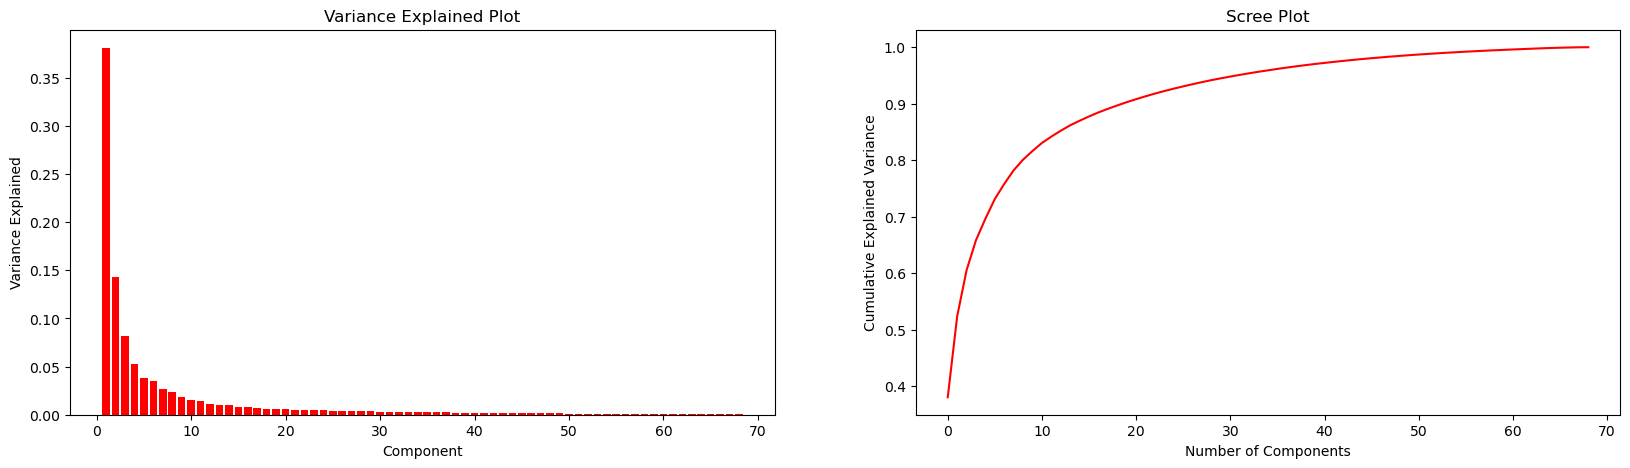

PC1 and PC2 explain 52.396% of the variance.


In [53]:
fig, ax = plt.subplots(1,2, figsize=(20,5))

ax[0].bar(np.arange(1, pca_df.shape[1]),pca.explained_variance_ratio_[0:pca_df.shape[1]-1], color = 'red')
ax[0].set_xlabel('Component')
ax[0].set_ylabel('Variance Explained')
ax[0].set_title('Variance Explained Plot')

ax[1].plot(np.cumsum(pca.explained_variance_ratio_), color = 'red')
ax[1].set_xlabel('Number of Components')
ax[1].set_ylabel('Cumulative Explained Variance')
ax[1].set_title('Scree Plot')

plt.savefig('Media/viz/01/01_pca_var_explained_and_screeplot')
plt.show()

print(f'PC1 and PC2 explain {np.sum(pca.explained_variance_ratio_[0:2])*100:.3f}% of the variance.')

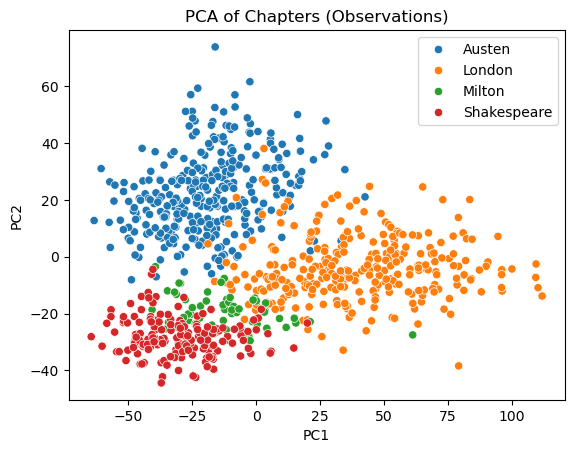

In [54]:
pca_chapters_df = pca_df.loc[:,['PC1','PC2']] # Nested and ordered; extract first 2 Principal Components
pca_chapters_df['Author'] = df['Author']

sns.scatterplot(data=pca_chapters_df, x='PC1', y='PC2', hue='Author', palette='tab10')
plt.title('PCA of Chapters (Observations)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.savefig('Media/viz/01/01_pca_chapters')
plt.show()

### Features

In [55]:
pca_words_df = pd.DataFrame(word_loadings)
cols = [f'PC{j+1}' for j in range(pca_words_df.shape[1])]
pca_words_df = pca_words_df.rename(columns = {i:cols[i] for i in range(pca_words_df.shape[1])})
pca_words_df.index = X.columns
pca_words_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC60,PC61,PC62,PC63,PC64,PC65,PC66,PC67,PC68,PC69
a,0.060676,0.076522,-0.315737,-0.055225,-0.078926,0.263739,0.484181,-0.525683,0.264041,0.219213,...,-0.005026,0.002127,-0.020590,-0.020622,-0.005487,-0.001468,0.006522,-0.002964,0.020486,0.001386
all,0.003003,0.000487,0.053015,-0.032618,0.066769,-0.029175,-0.009633,0.042661,0.058567,-0.200501,...,0.007117,-0.043006,0.021078,0.017012,-0.001458,0.008575,0.012527,0.033792,-0.014598,0.001157
also,0.007791,-0.000515,0.007859,0.001355,-0.008722,0.000714,0.000660,0.007541,0.003267,-0.006968,...,-0.002700,0.018310,-0.007202,-0.008381,-0.001825,0.006400,-0.019838,-0.093516,0.056643,0.989992
an,0.032094,-0.000843,-0.326638,-0.223061,0.188812,-0.163141,0.137205,0.060527,0.235075,-0.152501,...,-0.012955,-0.026053,-0.005756,0.020056,0.008385,-0.027075,0.000523,0.005918,0.007497,0.005771
and,0.223970,-0.060692,0.667811,-0.081825,-0.015979,0.543313,-0.035569,-0.145092,0.219987,-0.003553,...,-0.002065,0.003563,0.004656,-0.002794,0.001242,-0.004503,0.005302,-0.000100,0.000272,-0.005046
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
who,0.003630,-0.001030,0.052789,0.002280,0.002378,-0.013840,-0.007167,-0.006857,0.004959,-0.064097,...,-0.030093,-0.166349,0.078814,0.125654,-0.021114,-0.080313,0.096907,0.061265,-0.000161,-0.017311
will,-0.062244,-0.056680,-0.001381,0.124291,0.004152,0.024512,-0.127001,-0.070483,-0.042921,0.024465,...,0.029968,0.013908,0.020761,0.013775,0.006232,-0.059988,-0.017531,-0.003613,0.022391,-0.003819
with,-0.008282,-0.026201,0.128355,-0.102281,0.099969,-0.044243,0.033596,-0.015710,0.041990,0.047793,...,-0.006375,-0.009951,0.001977,-0.007391,0.009002,0.006421,-0.005216,0.012884,0.008480,-0.000474
would,-0.029127,0.078012,-0.025317,0.047541,-0.050614,0.034905,-0.062669,-0.037895,-0.032398,-0.054165,...,-0.024179,-0.008643,-0.011250,0.021813,0.022624,-0.031247,0.009858,-0.018687,-0.006684,-0.001789


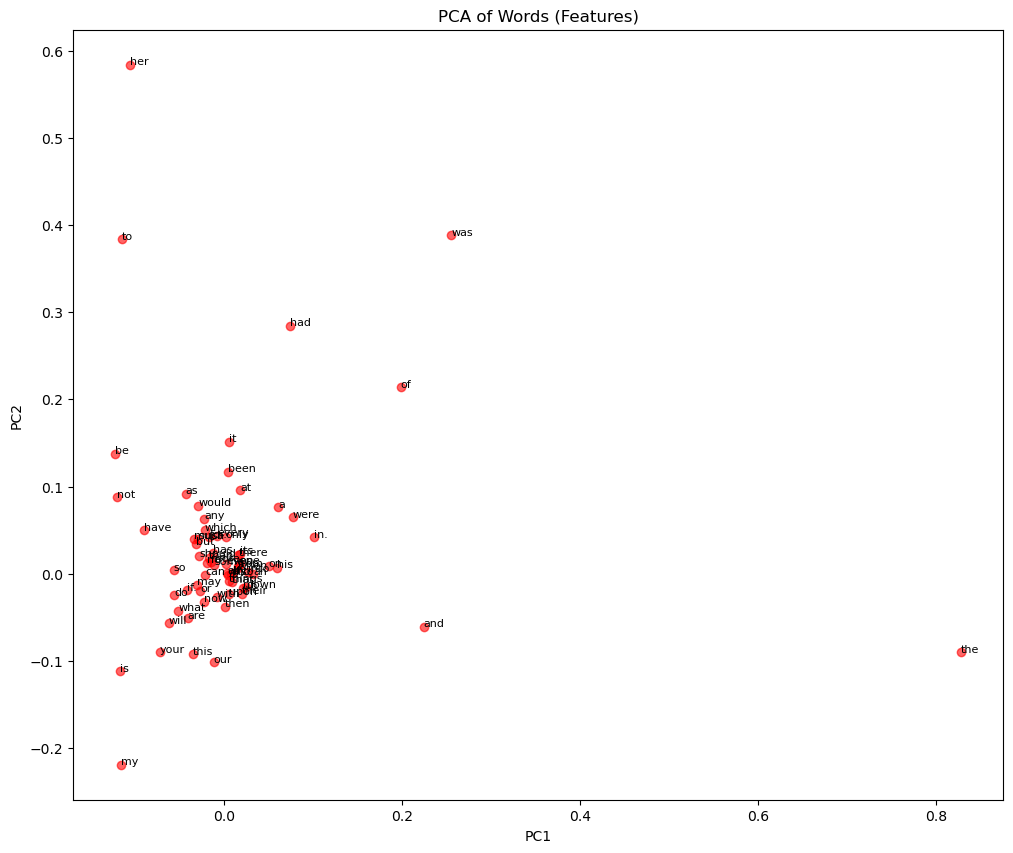

In [56]:
plt.figure(figsize=(12, 10))
plt.scatter(pca_words_df['PC1'], pca_words_df['PC2'], alpha=0.6, color = 'red')

for _, row in pca_words_df.iterrows():
    plt.text(row['PC1'], row['PC2'], row.name, fontsize=8)  # ← fixed here
plt.title('PCA of Words (Features)')
plt.xlabel('PC1')
plt.ylabel('PC2');
plt.savefig('Media/viz/01/01_pca_words')

This method offers poor visualization and little interpretability.  There are other methods that will provide more interpretability on the features such as NMF.

## NMF

NMF may perform strongly here because our word frequencies are non-negative! Furthermore, this method will provide semantic intuition by creating topics.

In [57]:
k = 4 # hyperparameter -> clusters
model = NMF(n_components=k, init='random', random_state=0, max_iter=500)

# dimensions -> (841 chapters, k topics)
W = model.fit_transform(X)

# dimensions -> (k topics, 69 words)
H = model.components_

### Observations

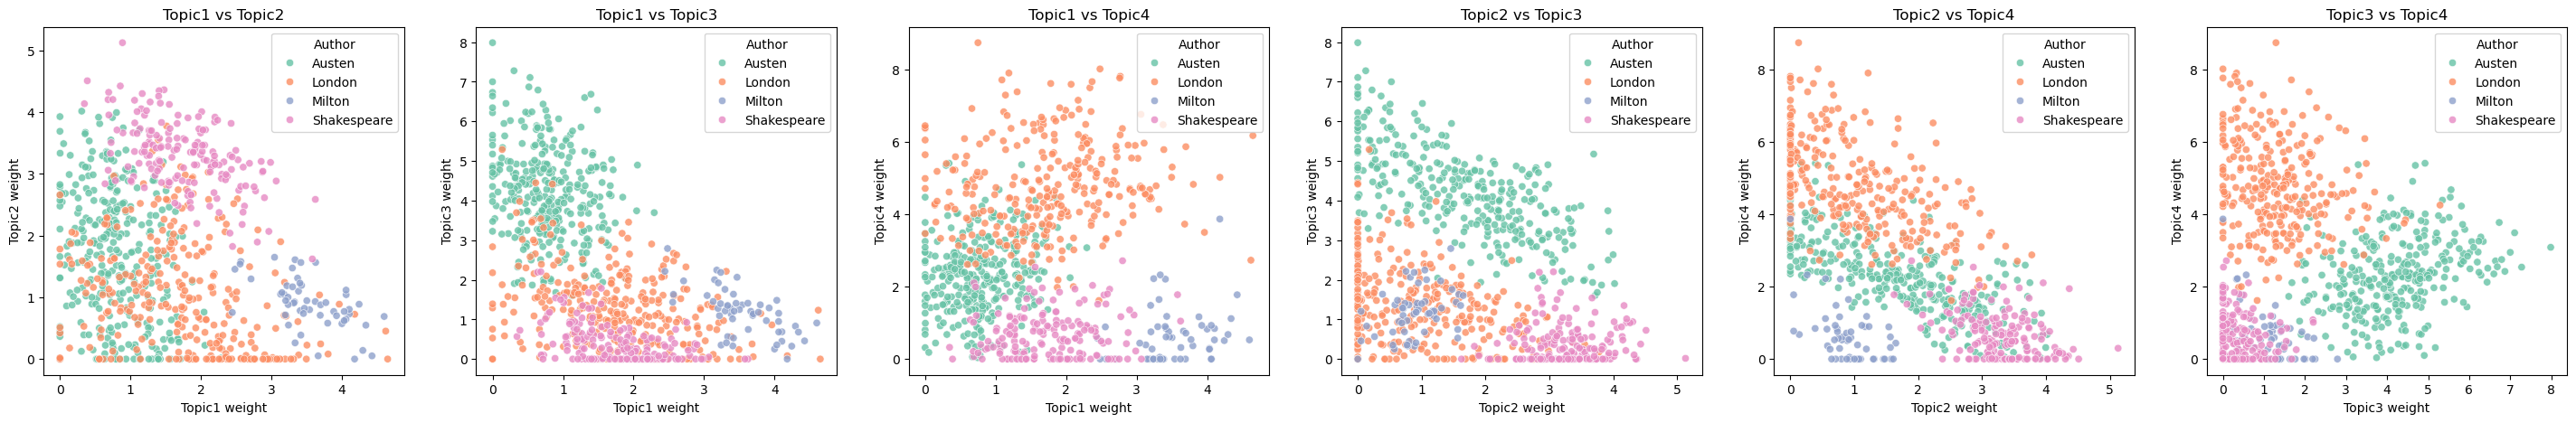

In [58]:
W_df = pd.DataFrame(W, index=X.index, columns=[f'Topic{i+1}' for i in range(k)]) # Turn W into a DataFrame with word labels
topic_df = W_df.reset_index(drop=True)
topic_df["Author"] = df["Author"].reset_index(drop=True)
topics = W_df.columns.tolist() # List of topic names
topic_pairs = list(combinations(topics, 2)) # All pairs of topics

n_plots = len(topic_pairs)
fig, axes = plt.subplots(nrows=1, ncols=n_plots, figsize=(6 * n_plots, 5))

if n_plots == 1:
    axes = [axes]

for i, (x_topic, y_topic) in enumerate(topic_pairs):
    ax = axes[i]
    sns.scatterplot(data=topic_df, x=x_topic, y=y_topic, hue="Author", palette="Set2", alpha=0.8, ax=ax)
    ax.set_title(f"{x_topic} vs {y_topic}")
    ax.set_xlabel(f"{x_topic} weight")
    ax.set_ylabel(f"{y_topic} weight")
    ax.legend().set_title("Author")

plt.savefig('Media/viz/01/01_nmf_observations')

This provides poor interpretability so it is clearly not our first choice when visualizing chapters/observations.

### Features

First of all the most simple and easy/inuitive vizualization of the features/words is just a simple total count!

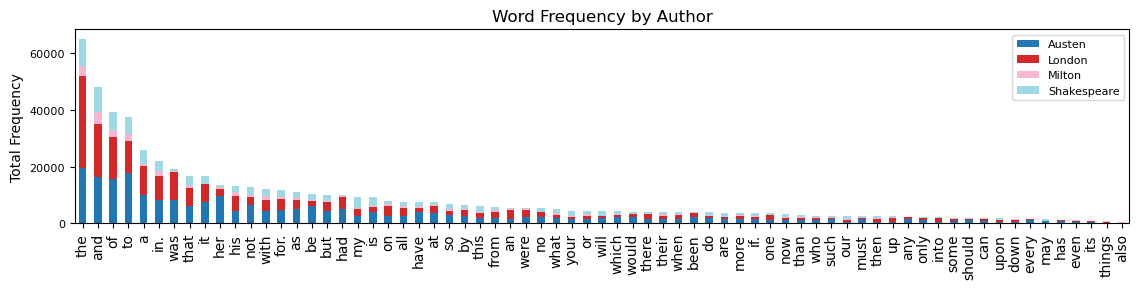

In [59]:
X_df = X.copy()
X_df['Author'] = authors
author_word_freq = X_df.groupby('Author').sum().T
author_word_freq = author_word_freq.loc[author_word_freq.sum(axis=1).sort_values(ascending=False).index]

fig, ax = plt.subplots(figsize=(len(author_word_freq)/6, 3))  # adjust based on # of words
author_word_freq.plot(
    kind='bar',
    stacked=True,
    ax=ax,
    colormap='tab20'
)

plt.title("Word Frequency by Author", fontsize=12)
plt.ylabel("Total Frequency", fontsize=10)
plt.xticks(rotation=90, fontsize=10)
plt.yticks(fontsize=8)
plt.legend(loc='upper right', fontsize=8)
plt.tight_layout()
plt.savefig("Media/viz/01/01_all_word_freq_by_author_stackedbar_condensed.png", dpi=300)
plt.show()



This is where NMF will truly shine.

In [60]:
n = 10 # Set here -> top words per topic!

In [61]:
word_topic_df = pd.DataFrame(H.T, index=X.columns, columns=[f"Topic{i+1}" for i in range(H.shape[0])]) # Transpose H to get words as rows, topics as columns
columns = list(word_topic_df.columns)
highest_n_weighted_words_per_topic = {}
for col in columns:
    words = list(word_topic_df[col].sort_values(ascending=False).head(n).index)
    highest_n_weighted_words_per_topic[col] = words
print(highest_n_weighted_words_per_topic)

{'Topic1': ['and', 'the', 'of', 'to', 'his', 'in.', 'with', 'from', 'all', 'their'], 'Topic2': ['the', 'a', 'to', 'my', 'is', 'of', 'it', 'that', 'not', 'and'], 'Topic3': ['to', 'her', 'and', 'of', 'was', 'be', 'not', 'had', 'as', 'it'], 'Topic4': ['the', 'was', 'of', 'a', 'and', 'in.', 'it', 'had', 'that', 'an']}


Below are semantic interpretations of each topic based on the top contributing words:

- **Topic 1 – Structural & Possessive Language**  
  Emphasizes grammatical connectors, possession, and sentence scaffolding — likely reflecting narrative structure or formal exposition.

- **Topic 2 – Determiners & Negation**  
  Centers on articles, pronouns, and simple negations, suggesting basic sentence formation and assertive language.

- **Topic 3 – Past-Tense Narration**  
  Highlights auxiliary verbs and past-tense forms, indicating descriptive or event-driven storytelling.

- **Topic 4 – Temporal & Descriptive Grammar**  
  Focuses on narrative tense, articles, and function words often used in unfolding sequences or descriptive prose.


These topics reflect broad grammatical and stylistic features common in text, helping differentiate author styles or narrative structures.


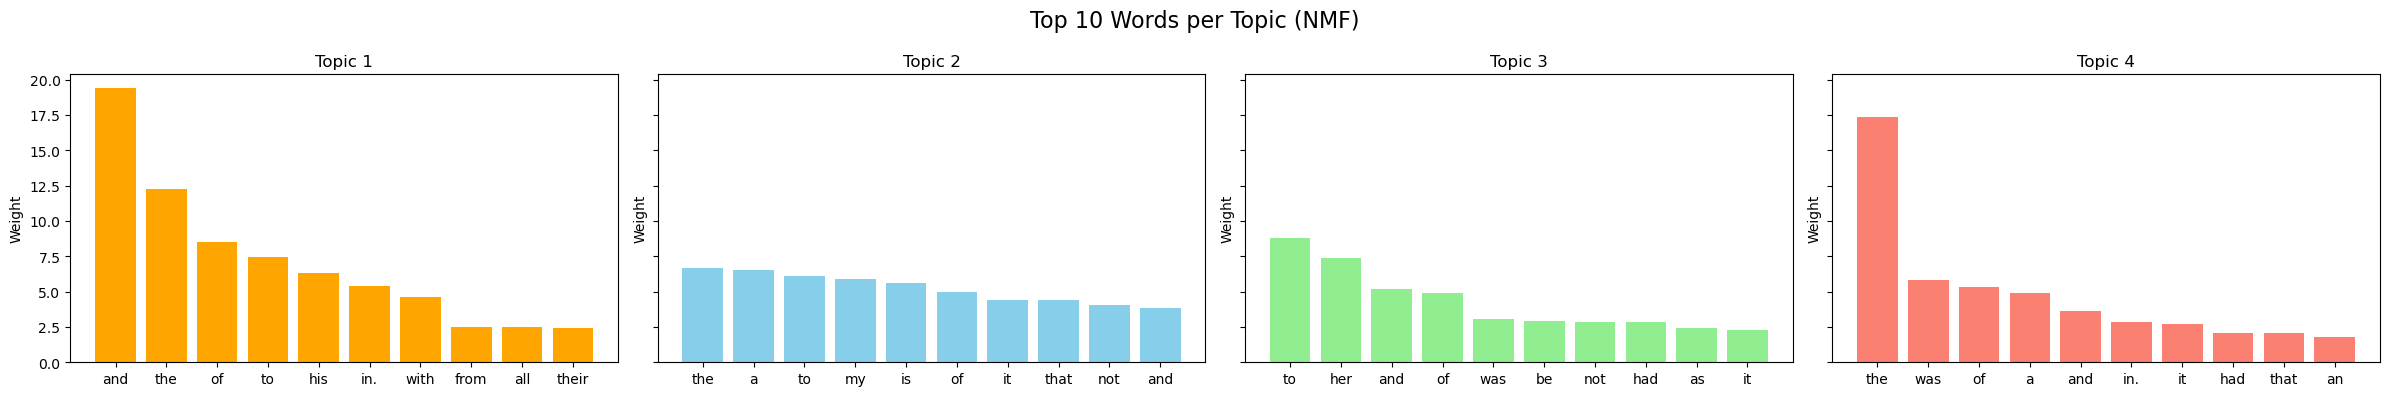

In [62]:
fig, axes = plt.subplots(1, H.shape[0], figsize=(6 * H.shape[0], 4), sharey=True)

colors = ['orange', 'skyblue', 'lightgreen', 'salmon']  # or however many topics you have
for topic_idx, ax in enumerate(axes):
    topic_weights = H[topic_idx]
    top_word_indices = topic_weights.argsort()[::-1][:n]
    top_words = [X.columns[i] for i in top_word_indices]
    top_scores = topic_weights[top_word_indices]
    ax.bar(top_words, top_scores, color=colors[topic_idx % len(colors)])
    ax.set_title(f"Topic {topic_idx + 1}")
    ax.set_ylabel("Weight")

fig.suptitle(f"Top {n} Words per Topic (NMF)", fontsize=16)
plt.tight_layout()
plt.savefig('Media/viz/01/01_nmf_top_words_per_topic')

#### Extra Feature Vizuals (not scientific)

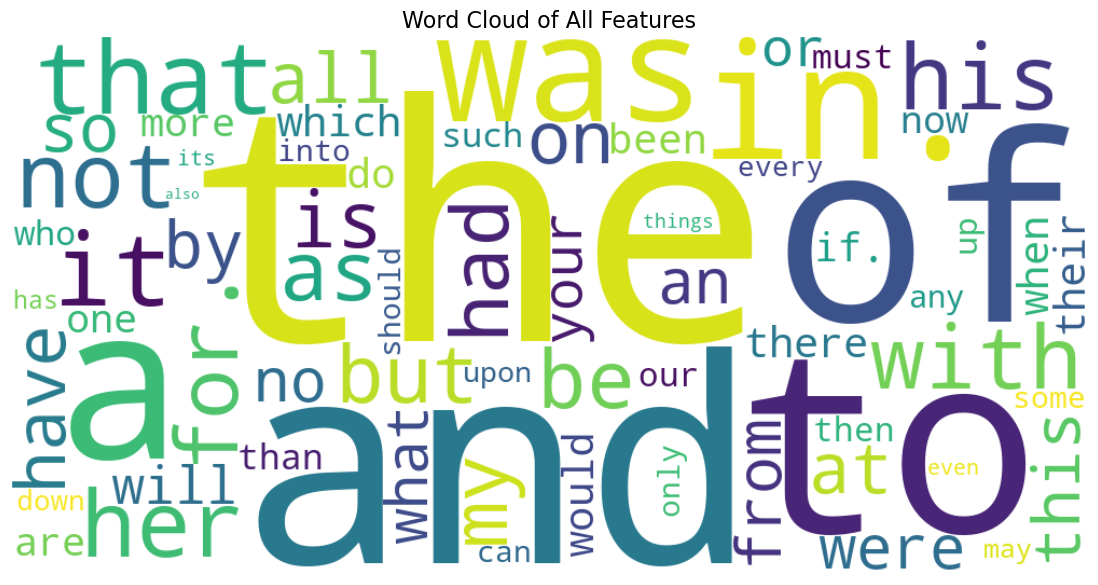

In [63]:
word_freq_dict = X.sum(axis=0).to_dict()

wordcloud = WordCloud(width=1000, height=500, background_color='white').generate_from_frequencies(word_freq_dict)

plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of All Features", fontsize=16)
plt.savefig('Media/viz/01/01_word_cloud')
plt.show()

Now let us try and use this to determine which chapters correspond to which topics and predict the author based on the semantics of each topic.

Establish a mapping by grouping by using the labels, grouping by Author and then evaluating the mean topic weights per author! First we should split our data into a training and testing.

In [64]:
W_df['Authors'] = df['Author']

# Split the data
train_df, test_df = train_test_split(W_df, test_size=0.2, random_state=42, stratify=W_df['Authors'])

print(f"Training samples: {len(train_df)}")
print(f"Testing samples: {len(test_df)}")


Training samples: 672
Testing samples: 169


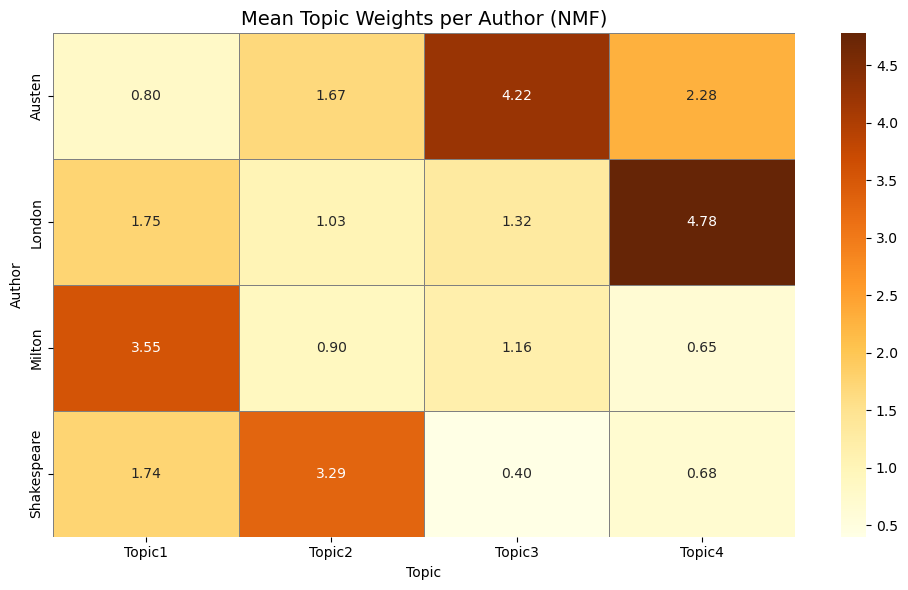

In [65]:
author_topic_means = train_df.groupby('Authors').mean() # Compute mean topic weights grouped by author
plt.figure(figsize=(10, 6))
sns.heatmap(author_topic_means, annot=True, fmt=".2f", cmap="YlOrBr", linewidths=0.5, linecolor='gray')
plt.title("Mean Topic Weights per Author (NMF)", fontsize=14)
plt.xlabel("Topic")
plt.ylabel("Author")
plt.tight_layout()
plt.savefig("Media/viz/01/01_nmf_author_topic_heatmap", dpi=300)

**Mean Topic Weights per Author (NMF)**

The heatmap above shows the average topic weights across all chapters written by each author. It is computed by grouping the NMF document-topic matrix (`W`) by author and taking the mean.

**Interpretation:**
- Each cell reflects how strongly a given author tends to express a specific topic.
- Higher values indicate that the author frequently uses patterns or structures associated with that topic.
- While no topic is exclusive to a single author, we observe distinct preferences:
  - **Milton** leans heavily on Topic 1
  - **Shakespeare** shows strong usage of Topic 2
  - **Austen** favors Topic 3
  - **London** stands out on Topic 4

This unsupervised representation helps reveal stylistic or grammatical tendencies across authors.


In [66]:
mapping = {'Topic3': 'Austen', 'Topic4': 'London', 'Topic1': 'Milton', 'Topic2': 'Shakespeare'}

Now lets evaluate this mapping on the test set!

In [67]:
test_df['Highest Weighted Topic'] = test_df.iloc[:, :4].idxmax(axis=1).values
test_df['Likely Author'] = test_df['Highest Weighted Topic'].apply(lambda x: mapping[x])
correct_proportion = (test_df['Likely Author'] == test_df['Authors']).mean()
print(f'This method was correct {correct_proportion*100:.4f}% of the time')

This method was correct 91.7160% of the time


This yields pretty good results!!

## MDS

### Observations

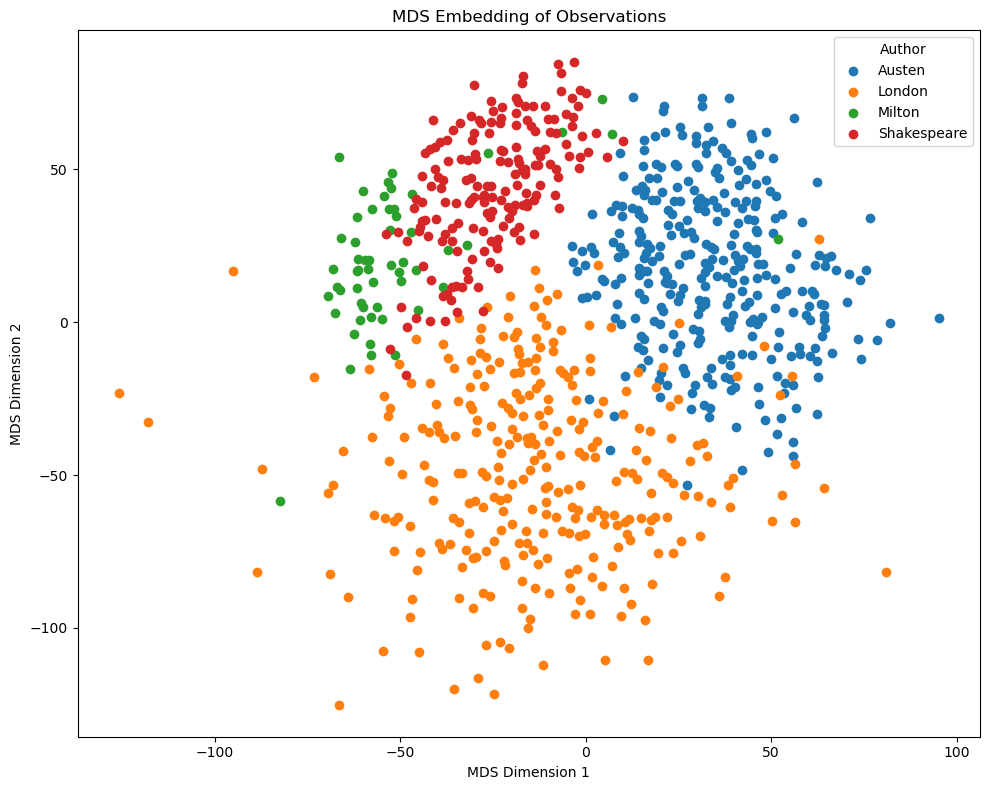

In [68]:
model = MDS(n_components=2, random_state=42)
X_mds = model.fit_transform(X)

unique_authors = sorted(set(authors))

# Plot
plt.figure(figsize=(10, 8))
for i, author in enumerate(unique_authors):
    mask = authors == author
    plt.scatter(X_mds[mask, 0], X_mds[mask, 1], label=author)

plt.xlabel("MDS Dimension 1")
plt.ylabel("MDS Dimension 2")
plt.title("MDS Embedding of Observations")
plt.legend(title="Author", loc="best")
plt.tight_layout()
plt.savefig("Media/viz/01/01_mds_observation_viz")
plt.show()


# Non-Linear Methods

## Spectral Embeddings

### Observations

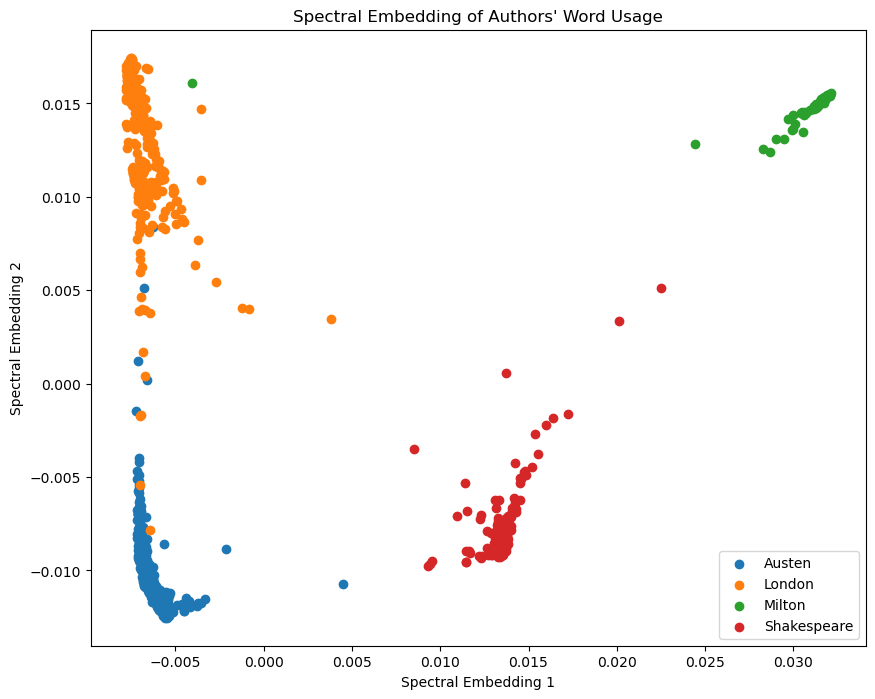

In [69]:
spectral = SpectralEmbedding(n_components=2, affinity='nearest_neighbors', n_neighbors=10)
X_spec = spectral.fit_transform(X)  # shape: (n_samples, 2)
spectral_df = pd.DataFrame(X_spec, columns=['Dim1', 'Dim2'])

plt.figure(figsize=(10, 8))
for author in ['Austen', 'London', 'Milton', 'Shakespeare']:
    mask = (authors == author)
    plt.scatter(X_spec[mask, 0], X_spec[mask, 1], label=author)
plt.xlabel("Spectral Embedding 1")
plt.ylabel("Spectral Embedding 2")
plt.title("Spectral Embedding of Authors' Word Usage")
plt.legend(loc="lower right")
plt.savefig('Media/viz/01/01_spectal_obs_viz')
plt.show()


### Features

Unlike PCA and NMF there are no components we can use to visualize the features in Spectral Embedding.  However, we can apply a transpose to our data and then reapply Spectral Embedding.

This procedure will yield results where:

- Two words will be close in the embedding if they tend to appear in the same chapters.

- This gives you a co-occurrence-like structure, driven by chapter usage.

- This is conceptually similar to Latent Semantic Analysis, just via graph-based distance instead of SVD.

In [70]:
X_transpose = X.T
X_transpose = X_transpose.rename(columns = {i:f'Chapter{i}' for i in range(df.shape[0])})
X_transpose

,Chapter0,Chapter1,Chapter2,Chapter3,Chapter4,Chapter5,Chapter6,Chapter7,Chapter8,Chapter9,...,Chapter831,Chapter832,Chapter833,Chapter834,Chapter835,Chapter836,Chapter837,Chapter838,Chapter839,Chapter840
a,46,35,46,40,29,27,34,38,34,54,...,46,48,39,22,28,32,16,22,25,26
all,12,10,2,7,5,8,8,6,12,8,...,4,2,5,13,7,4,5,15,4,4
also,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
an,3,7,3,4,6,3,15,2,5,6,...,3,9,10,5,7,6,5,3,8,2
and,66,44,40,64,52,42,44,67,50,44,...,43,45,38,47,45,33,49,48,59,62
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
who,8,3,4,5,2,6,4,6,1,3,...,1,0,2,4,2,3,0,0,2,3
will,4,5,5,3,4,3,9,7,2,5,...,7,10,8,9,7,11,11,12,22,11
with,9,14,15,22,21,18,11,15,13,15,...,18,11,26,12,8,17,20,15,23,19
would,1,8,3,4,10,4,6,3,12,6,...,2,6,2,6,3,5,2,1,4,0


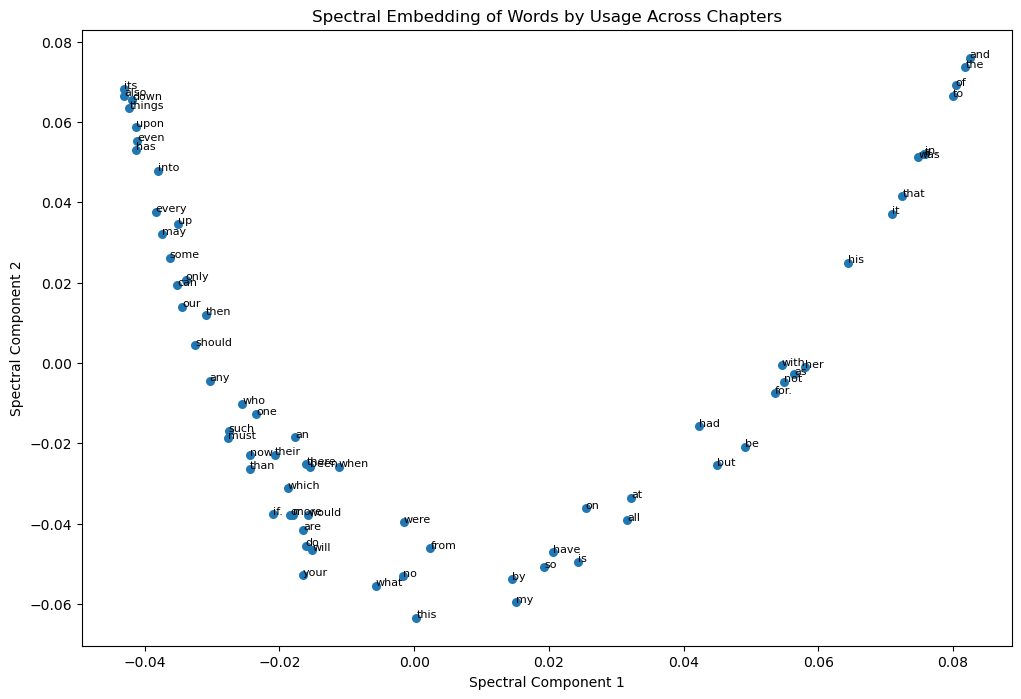

In [71]:
X_words = X_transpose.to_numpy()
spectral = SpectralEmbedding(n_components=2, affinity='nearest_neighbors', n_neighbors=10, random_state=0)
X_words_spec = spectral.fit_transform(X_words)

plt.figure(figsize=(12, 8))
plt.scatter(X_words_spec[:, 0], X_words_spec[:, 1], s=30)
for i, word in enumerate(X_transpose.index):
    plt.text(X_words_spec[i, 0], X_words_spec[i, 1], word, fontsize=8)
plt.title("Spectral Embedding of Words by Usage Across Chapters")
plt.xlabel("Spectral Component 1")
plt.ylabel("Spectral Component 2")
plt.savefig('Media/viz/01/01_spectral_feature_viz')
plt.show()


## UMAP

### Observations

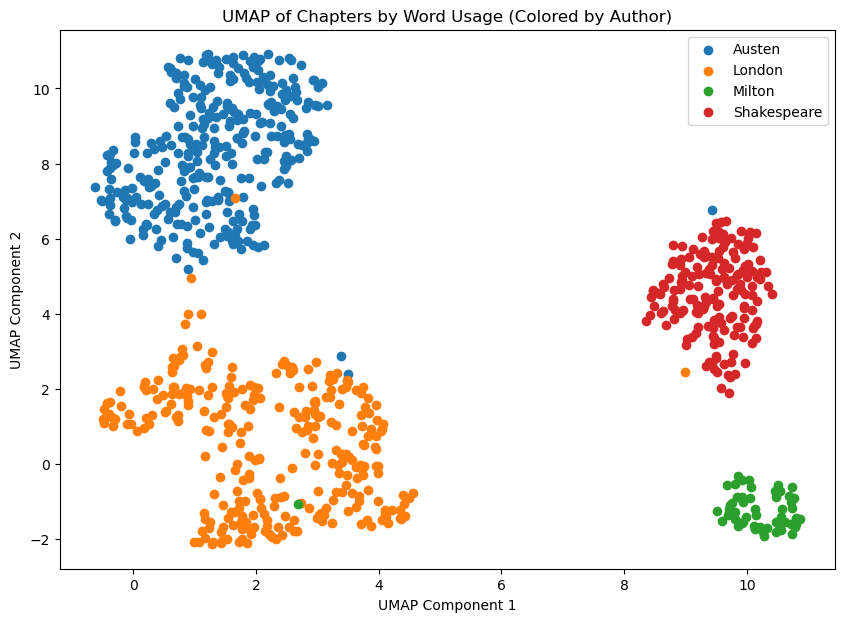

In [84]:
umap_model = umap.UMAP(n_neighbors=10, min_dist=0.3, n_jobs=-1) # Fit UMAP
X_umap = umap_model.fit_transform(X.to_numpy())

plt.figure(figsize=(10, 7))
for author in ['Austen', 'London', 'Milton', 'Shakespeare']:
    mask = (authors == author)
    plt.scatter(X_umap[mask, 0], X_umap[mask, 1], label=author)
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.title("UMAP of Chapters by Word Usage (Colored by Author)")
plt.legend(loc="upper right")
plt.savefig('Media/viz/01/01_umap_obs_viz')
plt.show()

plt.figure(figsize=(10, 7))
plt.scatter(X_umap[:,0],X_umap[:,1], color = 'purple')
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.title("UMAP")
plt.savefig('Media/viz/01/01_umap_viz_unlabeled');
plt.close()


UMAP does a very good job at creating seperable clusters! This visualization appears to be the best so far when observing observations (chapters)!

### Features

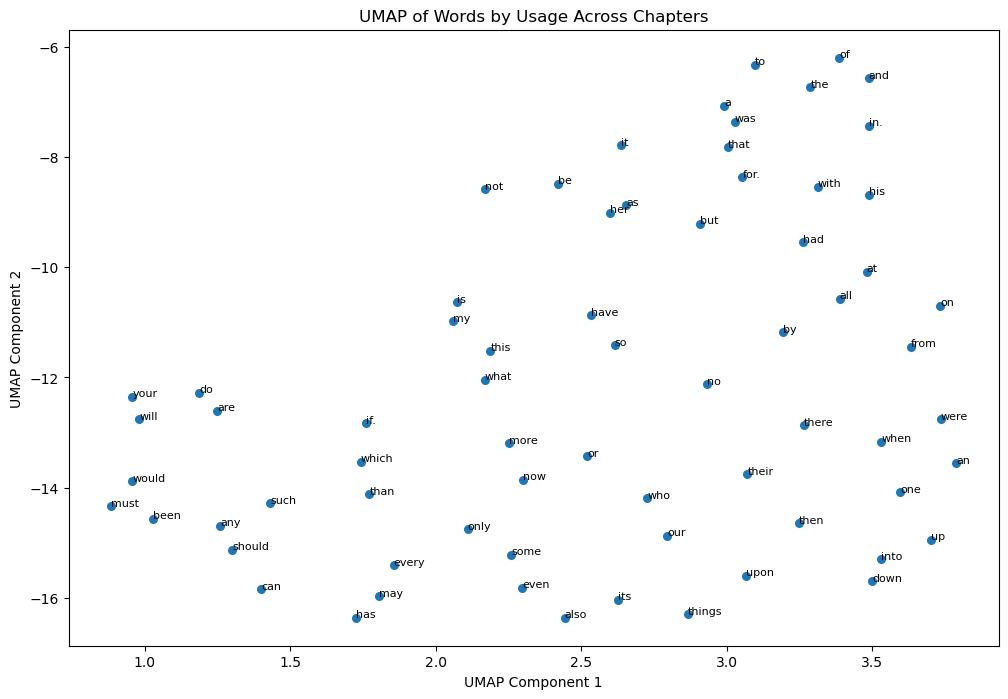

In [73]:
umap_model = umap.UMAP(n_neighbors=10, min_dist=0.3, n_jobs=-1) # Fit UMAP
X_words_umap = umap_model.fit_transform(X_transpose.to_numpy())

# Plot w/ word labels
plt.figure(figsize=(12, 8))
plt.scatter(X_words_umap[:, 0], X_words_umap[:, 1], s=30)
for i, word in enumerate(X_transpose.index):
    plt.text(X_words_umap[i, 0], X_words_umap[i, 1], word, fontsize=8)
plt.title("UMAP of Words by Usage Across Chapters")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.savefig('Media/viz/01/01_umap_feature_viz')
plt.show()


Not very interpretable/helpful.

## tSNE

### Observations

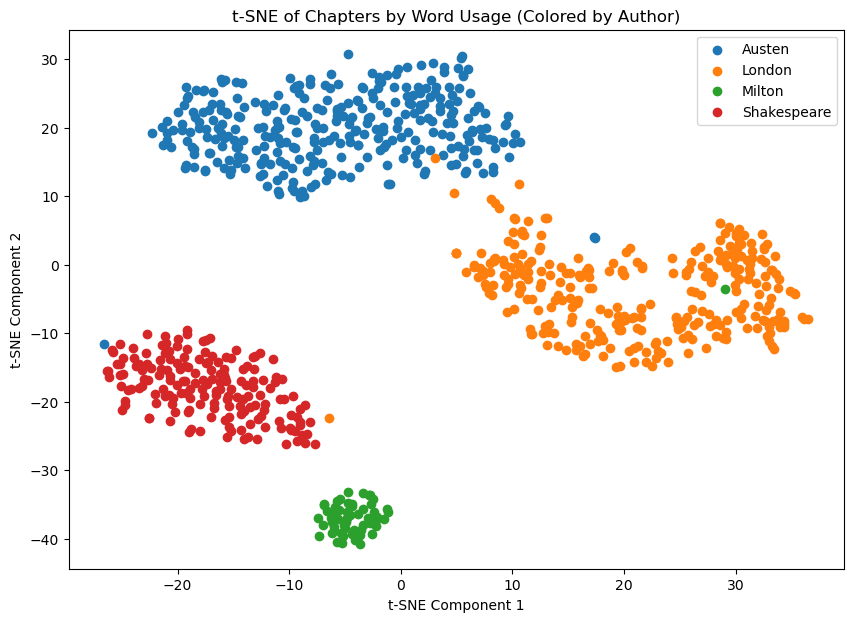

In [74]:
tsne = TSNE(n_components=2, perplexity=30, learning_rate='auto') # Fit t-SNE
X_tsne = tsne.fit_transform(X.to_numpy())

# Plot chapters with author labels
plt.figure(figsize=(10, 7))
for author in ['Austen', 'London', 'Milton', 'Shakespeare']:
    mask = (authors == author)
    plt.scatter(X_tsne[mask, 0], X_tsne[mask, 1], label=author)

plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("t-SNE of Chapters by Word Usage (Colored by Author)")
plt.legend(loc="upper right")
plt.savefig('Media/viz/01/01_tsne_obs_viz')
plt.show()


### Features

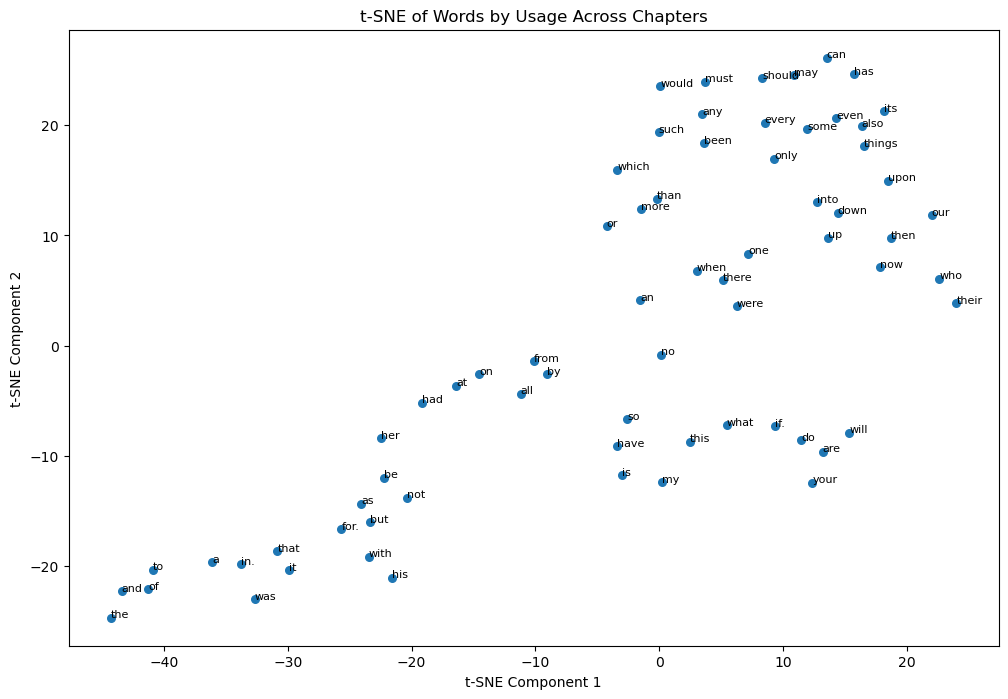

In [75]:
tsne = TSNE(n_components=2, perplexity=5, learning_rate='auto') # Fit t-SNE
X_words_tsne = tsne.fit_transform(X_words)

# Plot w/ word labels
plt.figure(figsize=(12, 8))
plt.scatter(X_words_tsne[:, 0], X_words_tsne[:, 1], s=30)
for i, word in enumerate(X_transpose.index):
    plt.text(X_words_tsne[i, 0], X_words_tsne[i, 1], word, fontsize=8)

plt.title("t-SNE of Words by Usage Across Chapters")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.savefig('Media/viz/01/01_tsne_feature_viz')
plt.show()


# Combined Visualizations

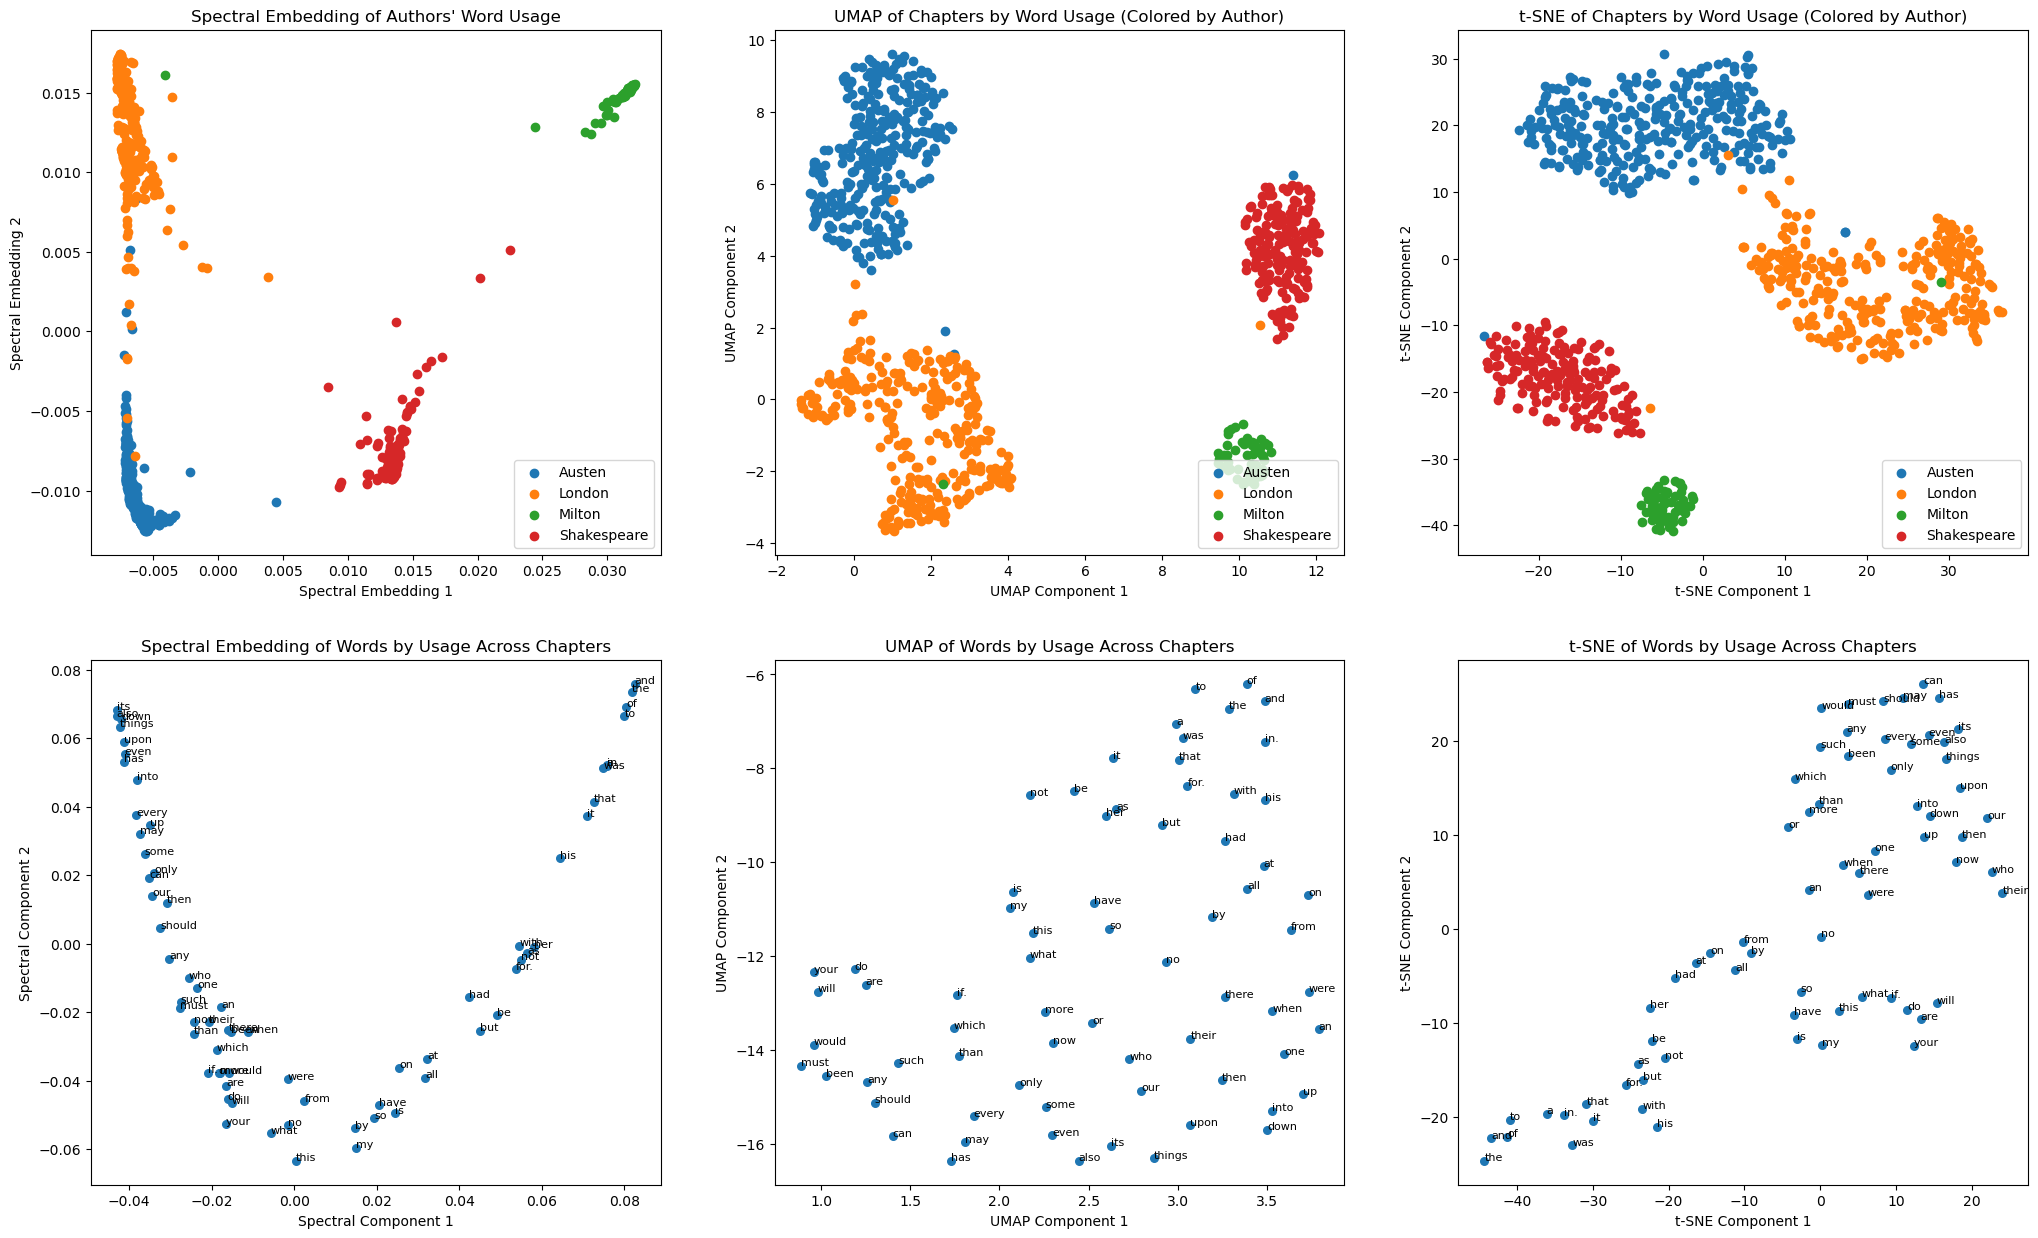

In [76]:
fig, ax = plt.subplots(2, 3, figsize=(25, 15), sharey=False)  # 1 row, 3 columns

# Spectral Embedding
for author in ['Austen', 'London', 'Milton', 'Shakespeare']:
    mask = (authors == author)
    ax[0,0].scatter(X_spec[mask, 0], X_spec[mask, 1], label=author)
ax[0,0].set_xlabel("Spectral Embedding 1")
ax[0,0].set_ylabel("Spectral Embedding 2")
ax[0,0].set_title("Spectral Embedding of Authors' Word Usage")
ax[0,0].legend(loc="lower right")

ax[1,0].scatter(X_words_spec[:, 0], X_words_spec[:, 1], s=30)
for i, word in enumerate(X_transpose.index):
    ax[1,0].text(X_words_spec[i, 0], X_words_spec[i, 1], word, fontsize=8)
ax[1,0].set_title("Spectral Embedding of Words by Usage Across Chapters")
ax[1,0].set_xlabel("Spectral Component 1")
ax[1,0].set_ylabel("Spectral Component 2")

# UMAP
for author in ['Austen', 'London', 'Milton', 'Shakespeare']:
    mask = (authors == author)
    ax[0,1].scatter(X_umap[mask, 0], X_umap[mask, 1], label=author)
ax[0,1].set_xlabel("UMAP Component 1")
ax[0,1].set_ylabel("UMAP Component 2")
ax[0,1].set_title("UMAP of Chapters by Word Usage (Colored by Author)")
ax[0,1].legend(loc="lower right")

ax[1,1].scatter(X_words_umap[:, 0], X_words_umap[:, 1], s=30)
for i, word in enumerate(X_transpose.index):
    ax[1,1].text(X_words_umap[i, 0], X_words_umap[i, 1], word, fontsize=8)
ax[1,1].set_title("UMAP of Words by Usage Across Chapters")
ax[1,1].set_xlabel("UMAP Component 1")
ax[1,1].set_ylabel("UMAP Component 2")

# tSNE
for author in ['Austen', 'London', 'Milton', 'Shakespeare']:
    mask = (authors == author)
    ax[0,2].scatter(X_tsne[mask, 0], X_tsne[mask, 1], label=author)
ax[0,2].set_xlabel("t-SNE Component 1")
ax[0,2].set_ylabel("t-SNE Component 2")
ax[0,2].set_title("t-SNE of Chapters by Word Usage (Colored by Author)")
ax[0,2].legend(loc="lower right")

ax[1,2].scatter(X_words_tsne[:, 0], X_words_tsne[:, 1], s=30)
for i, word in enumerate(X_transpose.index):
    ax[1,2].text(X_words_tsne[i, 0], X_words_tsne[i, 1], word, fontsize=8)
ax[1,2].set_title("t-SNE of Words by Usage Across Chapters")
ax[1,2].set_xlabel("t-SNE Component 1")
ax[1,2].set_ylabel("t-SNE Component 2")

plt.savefig('Media/viz/01/01_nonlinear_viz')
plt.show()

UMAP offers the best balance between global and local structure, preserves neighborhood quality, and gives interpretable groupings without as much distortion as t-SNE.

Clusters of words in the UMAP embedding reflect similar usage patterns across chapters.
Since word usage is shaped by topic and syntax, these local neighborhoods can be interpreted as reflecting semantic or grammatical similarity.
While UMAP does not preserve global distances, local groupings are meaningful.